# Generative Adverserial Networks
## Generative Models
A discriminative model learns a function that maps the input data (x) to some desired output class label (y). In probabilistic terms, they directly learn the conditional distribution P(y|x).

A generative model tries to learn the joint probability of the input data and labels simultaneously, i.e. P(x,y). This can be converted to P(y|x) for classification via Bayes rule, but the generative ability could be used for something else as well, such as creating likely new (x, y) samples.

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<img src="GAN.png">

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
n = X_train.shape[0]

In [4]:
X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [5]:
X_train /= 255
X_test /= 255

In [6]:
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

In [7]:
def noise(bs): return np.random.rand(bs,100)

In [8]:
x=noise(64)

In [9]:
x.shape

(64, 100)

In [10]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X,  + [1]*sz

In [11]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

In [12]:
gan_g = Sequential([
    Dense(512*7*7, input_dim=100),
    keras.layers.advanced_activations.LeakyReLU(),
    BatchNormalization(),
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Conv2D(64, (3, 3), padding='same'),
    keras.layers.advanced_activations.LeakyReLU(),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(32, (3, 3), padding='same'),
    keras.layers.advanced_activations.LeakyReLU(),
    BatchNormalization(),
    Conv2D(1, (1, 1), padding='same', activation='sigmoid')
])

In [13]:
gan_d = Sequential([
    Conv2D(256, (5,5), strides=(2,2), input_shape=(28, 28, 1)),
    keras.layers.advanced_activations.LeakyReLU(),
    Conv2D(512, (5,5), strides=(2,2)),
    keras.layers.advanced_activations.LeakyReLU(),
    Flatten(),
    Dense(256),
    keras.layers.advanced_activations.LeakyReLU(),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
gan_d.compile(Adam(1e-3), "binary_crossentropy")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Preliminary training to make discriminator competent enough to recognise real from noise

In [15]:
sz = n//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], gan_g.predict(noise(sz))])
gan_d.fit(x1, [0]*sz+[1]*sz, batch_size=128, epochs=1, verbose=1)


Epoch 1/1
600/600 [==============================] - 0s - loss: 0.5056     


In [17]:
gan_m = Sequential([gan_g, gan_d])
gan_m.compile(Adam(1e-4), "binary_crossentropy")

In [37]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(nb_epoch)):
        X,y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X,y))
        make_trainable(D, False)
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
    return dl,gl

In [39]:
dl, gl= train(gan_d, gan_g, gan_m, 5000)

100%|██████████| 5000/5000 [04:29<00:00, 18.54it/s]


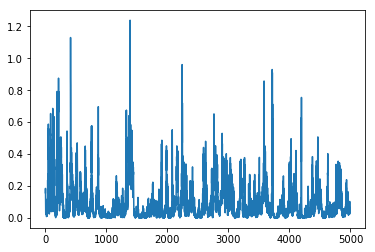

In [40]:
plt.plot(dl[10:])

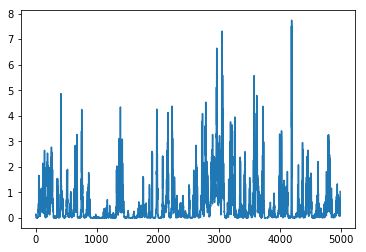

In [41]:
plt.plot(gl[10:])

Visualizing what the generator produces after training

In [44]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

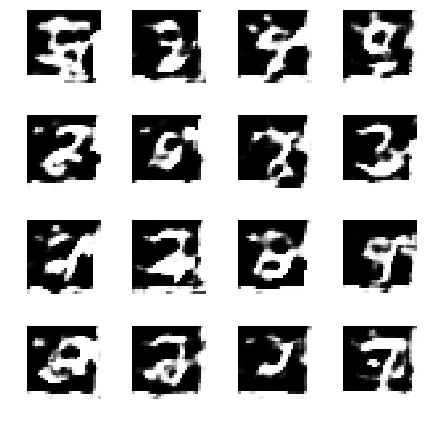

In [45]:
plot_gen(gan_g)